In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = './folliculitis_3'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

# DIR_WEIGHTS = '/kaggle/input/global-wheat-detection-public'

WEIGHTS_FILE = './fasterrcnn_resnet50_fpn.pth'

In [2]:
# 테스트 데이터프레임
# columns = ['image_id','PredictionString']
# image_id : 이미지 파일명
# PredictionString : 모델적용 후 bbox 값. 기본값 : 1.0 0 0 50 50 
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.shape

(10, 2)

In [3]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [4]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [5]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=10,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [8]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [105]:
detection_threshold = 0.75
results = []
score_list = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        score_list.append(scores)
        
        results.append(result)

In [106]:
results

[{'image_id': 'gen_0_5425', 'PredictionString': '0.8572 113 82 76 68'},
 {'image_id': 'gen_0_5431',
  'PredictionString': '0.9066 140 82 66 67 0.8330 0 153 58 63'},
 {'image_id': 'gen_0_5435', 'PredictionString': '0.7972 105 95 90 80'},
 {'image_id': 'gen_0_5445', 'PredictionString': '0.8210 84 67 87 135'},
 {'image_id': 'gen_0_5450', 'PredictionString': '0.8712 79 58 101 124'},
 {'image_id': 'gen_0_5455', 'PredictionString': '0.9045 12 14 109 136'},
 {'image_id': 'gen_0_5456', 'PredictionString': '0.7504 123 127 83 64'},
 {'image_id': 'gen_0_5469', 'PredictionString': '0.9743 20 116 72 87'},
 {'image_id': 'gen_0_5472', 'PredictionString': '0.9395 52 43 76 131'},
 {'image_id': 'gen_0_5475', 'PredictionString': ''}]

In [107]:
score_list

[array([0.8571833], dtype=float32),
 array([0.90664434, 0.8329988 ], dtype=float32),
 array([0.7971878], dtype=float32),
 array([0.8210261], dtype=float32),
 array([0.8711848], dtype=float32),
 array([0.9044905], dtype=float32),
 array([0.7504137], dtype=float32),
 array([0.97432125], dtype=float32),
 array([0.93945616], dtype=float32),
 array([], dtype=float32)]

In [108]:
len(score_list[9])

0

In [109]:
score_list[0][0]

0.8571833

In [110]:
box_count = 0
sum_score = 0
for scores in score_list:
    box_count += len(scores)
    for score in scores:
        sum_score += score
        
print(box_count, sum_score)

10 8.654906749725342


In [111]:
sum_score / box_count

0.8654906749725342

In [112]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,gen_0_5425,0.8572 113 82 76 68
1,gen_0_5431,0.9066 140 82 66 67 0.8330 0 153 58 63
2,gen_0_5435,0.7972 105 95 90 80
3,gen_0_5445,0.8210 84 67 87 135
4,gen_0_5450,0.8712 79 58 101 124


In [113]:
type(results)

list

In [114]:
type(results[0])

dict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


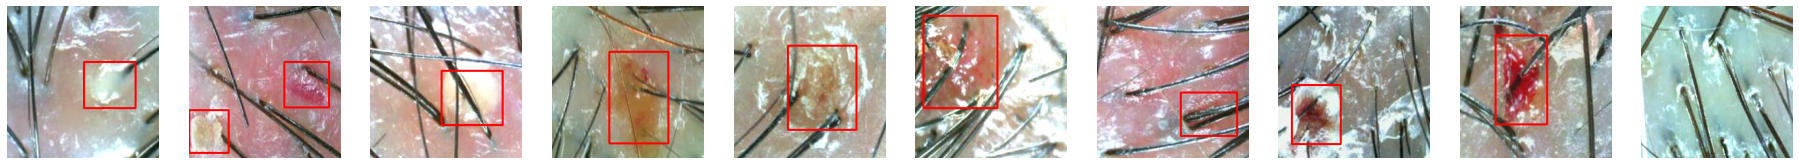

In [115]:
fig, ax = plt.subplots(1, 10, figsize=(32, 16))
i = 0
for image, output in zip(images, outputs):
    sample = image.permute(1,2,0).cpu().numpy()
    boxes = output['boxes'].data.cpu().numpy()
    scores = output['scores'].data.cpu().numpy()

    boxes = boxes[scores >=detection_threshold ].astype(np.int32)
    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
    ax[i].set_axis_off()
    ax[i].imshow(sample)
    i += 1

---

In [19]:
sample = images[2].permute(1,2,0).cpu().numpy()
boxes = outputs[2]['boxes'].data.cpu().numpy()
scores = outputs[2]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


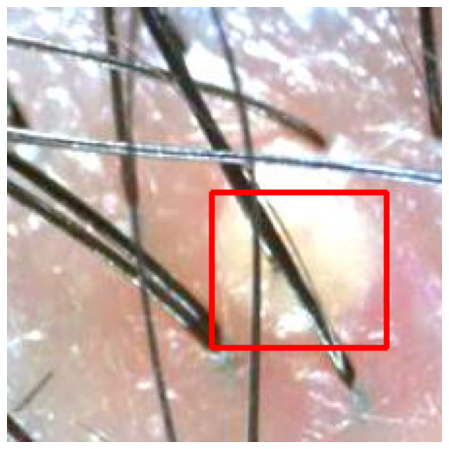

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [21]:
img_raw = cv2.imread(DIR_TEST+os.listdir(DIR_TEST)[2],cv2.IMREAD_COLOR)

In [22]:
img_raw = cv2.imread('gen_0_5435.jpg',cv2.IMREAD_COLOR)
for box in boxes:
    img_raw = cv2.rectangle(img_raw,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 0, 220), 2)
    
# imread : 이미지 호출 시 폴더path 들어가면 오류납니다

In [23]:
cv2.imwrite('prd.jpg', img_raw)

True

In [24]:
test_df.to_csv('predict.csv', index=False)

## 모델 사용 시 필요 작업

- 이미지 파일을 받으면 이미지파일명을 dataframe화 해야함
- dataframe : shape = (n,2), columns=['image_id', 'PredictionString']

---

## Object Detection 평가지표

- IoU
    - (Area of Overlap) / (Area of Union)
    - 1에 가까울 수록 잘 검출
    - Threshold로 옳게 검출된 기준값을 설정

- Recall = TP / (TP+FN) 
- Precision = TP / (TP + FP) 

- AP
    - Average Precision
    - IoU 값에 따른 Precision 값들의 평균
    $$\frac{1}{n}* \sum_{t=1}^n Precision(t)
    $$
    - n : threshold의 개수
    - Precision(t) : t번째 threshold 일 때의 precision 값

In [120]:
score_AP = pd.read_excel('./Score_AP.xlsx')
score_AP.drop(['Unnamed: 5','Unnamed: 6'], axis = 1, inplace = True)
score_AP

,Threshold,precision,recall,F1 score,AP
0,0.50,0.769231,1.0,0.869565,0.769231
1,0.55,0.833333,1.0,0.909091,0.801282
2,0.60,0.833333,1.0,0.909091,0.811966
3,0.65,0.909091,1.0,0.952381,0.836247
4,0.70,1.000000,1.0,1.000000,0.868998
5,0.75,1.000000,1.0,1.000000,0.890831
6,0.80,1.000000,0.8,0.888889,0.877855
7,0.85,1.000000,0.6,0.750000,0.843124
8,0.90,1.000000,0.4,0.571429,0.793888
9,0.95,1.000000,0.1,0.181818,0.724499


> threshold = 0.75 